# Prepare data

(we're doing this elsewhere now)

First we will create a dictionary of Semcor words, and look at them and their frequencies.


Next, we want to create a dataset of a subsample of semcor. We want to remove the most common and least common words


We limit this set in several ways:
    - only noun senses
    - max 30 examples of each sense of a word.
    - concrete
    - remove nominalizations, which tend to have eventive readings (we are interested in nouns denoting entities)

So, we begin iterating through a randomly shuffled semcor. For each word, we throw it out if it does not fit our criteria. Then, we look at the senses.



At the end, we store a list of all of the words we've collected. For each item in the dictionary, we should know:
- the number of tokens
- the wordnet senses
- a list of the semcor sentence indices of the tokens of each word. 


In [13]:
import sys
sys.path.append("../src/")
sys.path.append("..")

from nltk.corpus import semcor
#from nltk.tree import Tree
#import itertools
#import random
import pandas as pd
import torch
from bert import *
import csv
from nltk.corpus.reader.wordnet import Lemma
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer

import inflect
import os
from scipy.stats import spearmanr, pearsonr
import re
from src.utils import *




In [14]:
bert = BERTBase()


INFO:pytorch_pretrained_bert.modeling:loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /Users/gabriellachronis/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
INFO:pytorch_pretrained_bert.modeling:extracting archive file /Users/gabriellachronis/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /var/folders/9m/vzvx58rs51v_x5nm620fz4xr0000gn/T/tmpybc6znrm
INFO:pytorch_pretrained_bert.modeling:Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 3

# Predict feature vectors and save pairwise token data;
# Run correlation analysis;
# Saturate with other information;


    
All the old code that used to be above this is moot and improved. The eval data are already generated. We simply need to load in this file of eval data and work from there. 

Because you already have the data from the
    "Collect semcor eval data.ipynb" script
in the right format in the form of 
    [lemma, sense, word_form, context]
in the file
    "data/processed/semcor_eval_data_11_27_2021.csv"

In [18]:
"""
models and save paths
"""

models = [
    # commented models have already been run
    ## buchanan
    #'../trained_models/model.plsr.buchanan.allbuthomonyms.5k.300components.500max_iters',
    #'../trained_models/model.plsr.buchanan.allbuthomonyms.1k.300components.500max_iters',
    #'../trained_models/model.ffnn.buchanan.allbuthomonyms.5k.50epochs.0.5dropout.lr1e-4.hsize300',
    #'../trained_models/model.ffnn.buchanan.allbuthomonyms.1k.50epochs.0.5dropout.lr1e-4.hsize300',
    '../trained_models/model.modabs.buchanan.5k.mu1_1.mu2_0.1.mu3_0.001.mu4_5.nnk_4',
    '../trained_models/model.modabs.buchanan.1k.mu1_1.mu2_0.1.mu3_1e-07.mu4_10.nnk_4',


    ### mcrae
    #'../trained_models/model.plsr.mc_rae_real.allbuthomonyms.5k.100components.500max_iters',
    #'../trained_models/model.plsr.mc_rae_real.allbuthomonyms.1k.50components.500max_iters',
    #'../trained_models/model.ffnn.mc_rae_real.allbuthomonyms.5k.50epochs.0.5dropout.lr1e-4.hsize300',
    #'../trained_models/model.ffnn.mc_rae_real.allbuthomonyms.1k.50epochs.0.5dropout.lr1e-4.hsize300',
    '../trained_models/model.modabs.mc_rae_real.5k.mu1_1.mu2_0.1.mu3_0.001.mu4_5.nnk_4',
    '../trained_models/model.modabs.mc_rae_real.1k.mu1_1.mu2_0.1.mu3_1e-07.mu4_10.nnk_4',
    
    #### binder
    #'../trained_models/model.ffnn.binder.5k.50epochs.0.5dropout.lr1e-4.hsize300',
    #'../trained_models/model.ffnn.binder.1k.50epochs.0.5dropout.lr1e-4.hsize300',
    #'../trained_models/model.plsr.binder.5k.30components.500max_iters',
    #'../trained_models/model.plsr.binder.1k.30components.500max_iters',
    '../trained_models/model.modabs.binder.5k.mu1_1.mu2_0.1.mu3_0.001.mu4_5.nnk_4', # modabs binder 5k missing
    '../trained_models/model.modabs.binder.1k.mu1_1.mu2_0.1.mu3_0.001.mu4_5.nnk_4' # modabs binder 1k missing
    ]

In [19]:
for model in models:
    torch.load(model)

In [20]:
"""
Now, we have our dataset that we want to analyze. We just need to do:

for each model we want to evaluate, run the following script:

open the file of data

read it in as a dataframe

for each of the unique words in that dataset

    we calculate pairwise distances between each otoken and every otehr token
    and construct a similarities dataset. 
    
    add some extra infor about sense and polysemy bins
    
    and store into a file
    
    
    (no longer do this-then we run correlations for that word-???)

"""


def make_predictions(df, model, bert):
    """
    df has columns
    [lemma, sense, word_form, context]
    
    for a single semcor lemma
    """    
    predictions = []
    for index, row in df.iterrows():

        #print(row.word_form)
        #print(row.context)

        predicted_vector = model.predict_in_context(row.word_form, row.context, bert)

        predictions.append(predicted_vector)
    return predictions

def read_concreteness_values():
    """
    returns df with columns
    word
    Conc.M
    """
    brysbaert_filename = "/Users/gabriellachronis/data/Concreteness_ratings_Brysbaert_et_al_BRM.csv"
    concreteness_df = pd.read_csv(brysbaert_filename, sep='\t')
    concreteness_df= concreteness_df[["Word", "Conc.M"]]
    concreteness_df = concreteness_df.set_index("Word")
    return concreteness_df

def get_pairwise_wu_palmer_data(model, df, bert):
    
    """
    df has columns
    [lemma, sense, word_form, context]
    """
    
    # add concreteness
    concreteness_df = read_concreteness_values()
    df = df.join(concreteness_df, how = "left", on = "lemma")

    
    # storage
    run_stats = []
    vals = []
    item = 0

    # run through lemma by lemma
    unique_words = df.lemma.unique()
    for l in range(0, len(unique_words)):
        if l % 1000 == 0:
            print("processed %s lemmas" % l)
        
        # get a dataframe containing all the tokens of this word
        word = unique_words[l]
        word_data = df[df.lemma == word].copy()
        
        # lemma level info
        n_senses = len(word_data['sense'].unique())
        n_word_forms = len(word_data['word_form'].unique())
        
        # token level predictions
        predictions = make_predictions(word_data, model, bert)
        word_data['prediction'] = predictions
        
        


        """

        then we calculate the pairwise distances between all of the vectors, only counting one pair one time

        """

        # pop the first token off the list
        num_toks = len(word_data)
        for i in range(0,num_toks):
            item +=1
            if item % 1000 == 0:
                print("processed %s of %s tokens" % (item,num_toks))            
            # compare it with each of the other tokens
            # dont have to compare to any earlier
            for j in range(i+1,num_toks):

                #print(df.iloc[i])
                #print(df.iloc[j])

                # calculate cosine similarity between the two vectors
                cos_sim = 1 - cosine(word_data.iloc[i].prediction, word_data.iloc[j].prediction)

                # and wu palmer similarity between the two wn lemmas
                lemma1 = lemma_from_string(word_data.iloc[i].sense)
                lemma1_str = lemma_name_from_string(word_data.iloc[i].sense)
                lemma2 = lemma_from_string(word_data.iloc[j].sense)
                lemma2_str = lemma_name_from_string(word_data.iloc[j].sense)
                synset1 = lemma1.synset()
                synset2 = lemma2.synset()
                wup_sim = synset1.wup_similarity(synset2)

                # get other token level data
                pos1 = re.findall(r"\.(.*?)\.", lemma1_str)[0]
                pos2 = re.findall(r"\.(.*?)\.", lemma2_str)[0]
                concreteness = word_data.iloc[i]["Conc.M"]
                
                # if we can't compute a distance for these senses / recognize them, discard
                if type(wup_sim) == float:
                    # store this data point into a list
                    vals.append((word, lemma1_str, lemma2_str, pos1, pos2, cos_sim, wup_sim, n_senses, n_word_forms, concreteness))
        
    # turn results into dataframe
    columns = [
        "lemma",
        "token_sense_1",
        "token_sense_2",
        "sense1_pos",
        "sense2_pos",
        "cos_sim",
        "wup_sim", 
        "n_senses",
        "n_word_forms",
        "concreteness"]
    token_similarities = pd.DataFrame.from_records(vals, columns = columns)
        
    
    # add in bins
    token_similarities['wn_bin'] = pd.cut(token_similarities.n_senses, 
                        bins = [0, 2.1, 4.1, 6.1, 8.1, 10.1, 20.1, 50.1, 200], labels = False)
    token_similarities['conc_bin'] = pd.cut(token_similarities.concreteness, 
                        bins = [0, 1.5, 2.5, 3.5, 4.5, 10], labels = False)
   
    return token_similarities

        
        

def plot_sims():
    cos_sims = sense_similarities['cos_sim']
    wup_sims = sense_similarities['wup_sim']
    plt.scatter(wup_sims, cos_sims)
    plt.title("Wordnet similarity of homonymous senses plotted against cosine similarity of predicted vectors of two tokens in semantic feature space")
    plt.xlabel("Wu and Palmer Similarity")
    plt.ylabel("Cosine Similarity")
    plt.show()
        

In [21]:


# we need the default na option turned off bc the word/lemma 'null' was being interpreted as 'NaN'
names = ["lemma", "sense", "word_form", "context"]
df = pd.read_csv('../data/processed/semcor_eval_data_11_27_2021.csv', names = names , keep_default_na=False)

for save_path in models:
    print("****************************************")
    print("*** Evaluating %s model ***" % save_path)
    print("****************************************")
    model = torch.load(save_path)
    out_path = '../results/semcor_pairwise_data_' + os.path.split(save_path)[1] + '.csv'    

    # remove results file if exists
    if os.path.exists(out_path):
        os.remove(out_path)
    pairwise_data = get_pairwise_wu_palmer_data(model, df, bert)
    pairwise_data.to_csv(out_path)


****************************************
*** Evaluating ../trained_models/model.modabs.buchanan.5k.mu1_1.mu2_0.1.mu3_0.001.mu4_5.nnk_4 model ***
****************************************
processed 0 lemmas
processed 1000 of 118 tokens
processed 2000 of 47 tokens
processed 3000 of 85 tokens
processed 4000 of 86 tokens
processed 5000 of 77 tokens
processed 6000 of 69 tokens
processed 7000 of 24 tokens
processed 8000 of 34 tokens
processed 9000 of 17 tokens
processed 10000 of 58 tokens
processed 11000 of 31 tokens
processed 12000 of 65 tokens
processed 13000 of 14 tokens
processed 14000 of 58 tokens
processed 15000 of 37 tokens
processed 16000 of 29 tokens
processed 17000 of 20 tokens
processed 18000 of 28 tokens
processed 19000 of 51 tokens
processed 20000 of 24 tokens
processed 21000 of 56 tokens
processed 22000 of 18 tokens
processed 23000 of 97 tokens
processed 24000 of 28 tokens
processed 1000 lemmas
processed 25000 of 8 tokens
processed 26000 of 34 tokens
processed 27000 of 4 tokens


processed 21000 of 56 tokens
processed 22000 of 18 tokens
processed 23000 of 97 tokens
processed 24000 of 28 tokens
processed 1000 lemmas
processed 25000 of 8 tokens
processed 26000 of 34 tokens
processed 27000 of 4 tokens
processed 28000 of 21 tokens
processed 29000 of 105 tokens
processed 30000 of 86 tokens
processed 31000 of 16 tokens
processed 32000 of 17 tokens
processed 33000 of 46 tokens
processed 34000 of 31 tokens
processed 35000 of 27 tokens
processed 36000 of 49 tokens
processed 37000 of 58 tokens
processed 38000 of 18 tokens
processed 2000 lemmas
processed 39000 of 25 tokens
processed 40000 of 25 tokens
processed 41000 of 6 tokens
processed 42000 of 44 tokens
processed 43000 of 8 tokens
processed 44000 of 3 tokens
processed 45000 of 7 tokens
processed 46000 of 9 tokens
processed 47000 of 2 tokens
processed 3000 lemmas
processed 48000 of 4 tokens
processed 49000 of 13 tokens
processed 50000 of 15 tokens
processed 51000 of 4 tokens
processed 52000 of 10 tokens
processed 4000 

In [8]:
brysbaert_filename = "/Users/gabriellachronis/data/Concreteness_ratings_Brysbaert_et_al_BRM.csv"
concreteness_df = pd.read_csv(brysbaert_filename, sep='\t')
concreteness_df= concreteness_df[["Word", "Conc.M"]]
concreteness_df = concreteness_df.set_index("Word")
concreteness_df.head()

Conc.M
Word                 
roadsweeper      4.85
traindriver      4.54
tush             4.45
hairdress        3.93
pharmaceutics    3.77

In [ ]:
# just a little test
# lemma_from_string(csv_input.iloc[0].token_sense_1)

In [ ]:
"""
Now we need to go in and add abstractness value and 
bin number of senses into polysemy band

(already done since we fixed above)
"""



# import pandas as pd

# #cols = ["lemma", "token_sense_1", "token_sense_2", "cos_sim", "wup_sim", "n_senses"]


# for save_path in models:
#     print("****************************************")
#     print("*** Saturating pairwise data for model: %s ***" % save_path)
#     print("****************************************")
#     infile = '../results/semcor_pairwise_data_' + os.path.split(save_path)[1] + '.csv'

#     outfile = '../results/saturated_semcor_pairwise_data_' + os.path.split(save_path)[1] + '.csv'

    
#     dtype = {
#         'lemma':             str,
#         'token_sense_1':     object,
#         'token_sense_2':     object,
#         'cos_sim':           float,
#         'wup_sim':           float,
#         'n_senses':          float   
#     }
#     csv_input = pd.read_csv(infile, encoding_errors='ignore') #, names=cols) # requires pandas 1.3
#     #csv_input = pd.read_csv(infile)
    
#     print(len(csv_input))
    
#      # filtering out the rows with `POSITION_T` value in corresponding column
#     csv_input = csv_input[csv_input.token_sense_1.str.contains('token_sense_1') == False]
    
#     print(len(csv_input))
# #     print(csv_input.dtypes)

    
#     csv_input = csv_input.convert_dtypes(convert_floating=True)
    
# #     print(csv_input.dtypes)
    
#     print(csv_input.head())

    
#     # add polysemy bin
#     csv_input['wn_bin'] = pd.cut(csv_input.n_senses, 
#                         bins = [0, 2.1, 4.1, 6.1, 8.1, 10.1, 20.1, 50.1, 200], labels = False)


#     # add POS rows
#     pos1s = []
#     pos2s = []
#     sense1s = []
#     sense2s = []
#     for index, row in csv_input.iterrows():
#         pos1 = re.findall(r"\.(.*?)\.", row.token_sense_1)[0]
#         pos2 = re.findall(r"\.(.*?)\.", row.token_sense_2)[0]
#         pos1s.append(pos1)
#         pos2s.append(pos2)
#         sense1 = lemma_name_from_string(row.token_sense_1)
#         sense2 = lemma_name_from_string(row.token_sense_2)
#         sense1s.append(sense1)
#         sense2s.append(sense2)
        
#     csv_input['sense1_pos'] = pos1s
#     csv_input['sense2_pos'] = pos2s
#     csv_input['token_sense_1'] = sense_1s
#     csv_input['token_sense_2'] = sense_2s
    
    
#     # add concreteness
#     csv_input = csv_input.join(concreteness_df, how = "left", on = "lemma")
    
#     csv_input['conc_bin'] = pd.cut(csv_input['Conc.M'], 
#                         bins = [0, 2.3, 4.5, 10], labels = False)
    
#     # remove token sense columns
# #     csv_input.drop(['token_sense_1'], axis=1)
# #     csv_input.drop(['token_sense_2'], axis=1)
    
#     #print(csv_input.where(csv_input['Conc.M'].notnull()))
#     print(csv_input.head(20))
    
#     raise Exception("dewfieow")
    
#     csv_input.to_csv(outfile, index=False)
    


# Run Correlation analysis

In [22]:
"""
and now we make another dataset for each one with the correlations.
first we define some functions
"""

def run_correlation(sense_similarities):
    """
    input
    :sense_similarities: dataframe with columns
        cosine_sims 
        wup_sims
    output
    4-tuple with
        pearson
        pearson_p
        spearman
        spearman_p
    """
    #print(sense_similarities.head())
    
#     if sense_similarities is None:
#         # not really sure why we're getting none values here it should be impossible
#         return (float("nan"), float("nan"), float("nan"), float("nan"))
#     elif len(sense_similarities['wup_sim'].unique()) == 1:

    # if we only have 1 sense represented in semcor
    # the correlation will be garbage with a constant y value; skip to avoid warnings
    if sense_similarities.iloc[0]['n_senses'] == 1:
        return (float("nan"), float("nan"), float("nan"), float("nan"))

    if len(sense_similarities) > 1 :
        #print(word)

        cos_sims = sense_similarities['cos_sim']
        wup_sims = sense_similarities['wup_sim']

        pearson, pearson_p = pearsonr(cos_sims, wup_sims )
        #print('Pearsons correlation: %.3f, p-value: %s'  % (pearson, pearson_p))

        spearman, spearman_p = spearmanr(cos_sims, wup_sims )
        #print('Spearmans correlation: %.3f, p-value: %s'  % (spearman, spearman_p))

        return (pearson, pearson_p, spearman, spearman_p)
    
    # if we don't have enough, return dummies
    print("not enough examples of lemma: ", sense_similarities.iloc[0].lemma)
    return (float("nan"), float("nan"), float("nan"), float("nan"))

def plot_sims():
    cos_sims = sense_similarities['cos_sim']
    wup_sims = sense_similarities['wup_sim']
    plt.scatter(wup_sims, cos_sims)
    plt.title("Wordnet similarity of homonymous senses plotted against cosine similarity of predicted vectors of two tokens in semantic feature space")
    plt.xlabel("Wu and Palmer Similarity")
    plt.ylabel("Cosine Similarity")
    plt.show()

In [ ]:
#debug_df = pd.read_csv('../results/debug_semcor_pairwise_data_model.plsr.buchanan.allbuthomoyms.5k.300components.500max_iters.csv')
#debug_df[debug_df.lemma=='tan']

In [81]:
#debug_df = pd.read_csv('../data/semcor_eval_data_11_27_2021.csv', names = ["lemma", "sense", "wordform", "context"])
#debug_df[debug_df.lemma=='tan']

lemma                    sense wordform  \
53086  herb  Lemma('herb.n.01.herb')    herbs   
53087  herb  Lemma('herb.n.02.herb')    herbs   

                                                 context  
53086  Gazing at her husband 's drugged body , his ch...  
53087  She stood still over the leg of lamb , rubbing...

okay so the problem we are running into is that sometimes theres just one value per lemma, when we have two senses and only one token per sense in the dataset. we can fix this

In [23]:
"""
then we run it
"""


for save_path in models:

    print("****************************************")
    print("*** Running correlation on  %s model ***" % save_path)
    print("****************************************")
    infile = '../results/semcor_pairwise_data_' + os.path.split(save_path)[1] + '.csv'
    outfile = '../results/semcor_analysis_' + os.path.split(save_path)[1] + '.csv'
    print("reading from ", infile)
    out_data = []
    
    """
    infile pairwise data columns
        "lemma",
        "token_sense_1",
        "token_sense_2",
        "sense1_pos",
        "sense2_pos",
        "cos_sim",
        "wup_sim", 
        "n_senses",
        "n_word_forms",
        "concreteness"
        "wn_bin"
        "conc_bin"
    """

    df = pd.read_csv(infile)
    
    lemmas = df.lemma.unique()
    #print(lemmas[:10])

    for word in lemmas:
        word_data = df[df.lemma == word]
        
        n_senses = word_data.iloc[0].n_senses
        polysemy_bin = word_data.iloc[0].wn_bin
        concreteness_bin = word_data.iloc[0].conc_bin
        
        pearson, pearson_p, spearman, spearman_p = run_correlation(word_data)
        row = (word, len(word_data), n_senses, polysemy_bin, concreteness_bin, pearson, pearson_p, spearman, spearman_p)
        #print(corr)
        out_data.append(row)
        
        #raise Exception("hfjesh")
    
    print("writing to ", outfile)
    out_df = pd.DataFrame.from_records(out_data, columns = ['word', 'n', 'n_senses', 'polysemy_bin', 'concreteness_bin', 'pearson', 'pearson_p', 'spearman', 'spearman_p'] )
    out_df.to_csv(outfile)
    
    
    #for word in 
    #run_correlation()
    #cols = ["lemma", "token_sense_1", "token_sense_2", "cos_sim", "wup_sim", "n_senses"]
    #df = csv_input = pd.read_csv(infile, names=cols)
    
    

****************************************
*** Running correlation on  ../trained_models/model.modabs.buchanan.5k.mu1_1.mu2_0.1.mu3_0.001.mu4_5.nnk_4 model ***
****************************************
reading from  ../results/semcor_pairwise_data_model.modabs.buchanan.5k.mu1_1.mu2_0.1.mu3_0.001.mu4_5.nnk_4.csv


/usr/local/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


not enough examples of lemma:  tan
not enough examples of lemma:  velour
not enough examples of lemma:  hillbilly
not enough examples of lemma:  scouring
not enough examples of lemma:  inferiority
not enough examples of lemma:  shibboleth
not enough examples of lemma:  traditionalism
not enough examples of lemma:  bawh
not enough examples of lemma:  carelessness
not enough examples of lemma:  scraping
not enough examples of lemma:  emanation
not enough examples of lemma:  wattle
not enough examples of lemma:  privy
not enough examples of lemma:  penance
not enough examples of lemma:  reverse
not enough examples of lemma:  surrender
not enough examples of lemma:  mask
not enough examples of lemma:  pulse
not enough examples of lemma:  noun
not enough examples of lemma:  disregard
not enough examples of lemma:  subscription
not enough examples of lemma:  brotherhood
not enough examples of lemma:  bankruptcy
not enough examples of lemma:  booth
not enough examples of lemma:  small
not eno

not enough examples of lemma:  northeast
not enough examples of lemma:  hollyhock
not enough examples of lemma:  brooding
not enough examples of lemma:  aggressor
not enough examples of lemma:  tumbler
not enough examples of lemma:  portrayal
not enough examples of lemma:  inspiration
not enough examples of lemma:  pavement
not enough examples of lemma:  hypocrisy
not enough examples of lemma:  chorus
not enough examples of lemma:  toll
not enough examples of lemma:  claw
not enough examples of lemma:  palette
not enough examples of lemma:  hint
not enough examples of lemma:  consolidation
not enough examples of lemma:  coverage
not enough examples of lemma:  attainment
not enough examples of lemma:  southwest
not enough examples of lemma:  bathing
not enough examples of lemma:  assyrian
not enough examples of lemma:  nymph
not enough examples of lemma:  equality
not enough examples of lemma:  exterior
not enough examples of lemma:  symbolism
not enough examples of lemma:  fermentation

not enough examples of lemma:  flush
not enough examples of lemma:  bass
not enough examples of lemma:  open
not enough examples of lemma:  coordination
not enough examples of lemma:  peculiarity
not enough examples of lemma:  video
not enough examples of lemma:  pickup
not enough examples of lemma:  stubbornness
not enough examples of lemma:  trim
not enough examples of lemma:  illumination
not enough examples of lemma:  shit
not enough examples of lemma:  abode
not enough examples of lemma:  accompaniment
not enough examples of lemma:  jelly
not enough examples of lemma:  feast
not enough examples of lemma:  rot
not enough examples of lemma:  thaw
not enough examples of lemma:  humming
not enough examples of lemma:  ministry
not enough examples of lemma:  contemplation
not enough examples of lemma:  shrubbery
not enough examples of lemma:  pretence
not enough examples of lemma:  pharmacy
not enough examples of lemma:  calendar
not enough examples of lemma:  antecedent
not enough exam

not enough examples of lemma:  orgy
not enough examples of lemma:  mentality
not enough examples of lemma:  down
not enough examples of lemma:  marking
not enough examples of lemma:  dissent
not enough examples of lemma:  allocation
not enough examples of lemma:  hound
not enough examples of lemma:  detachment
not enough examples of lemma:  mouthpiece
not enough examples of lemma:  infliction
not enough examples of lemma:  allegation
not enough examples of lemma:  falsity
not enough examples of lemma:  lad
not enough examples of lemma:  hysteria
not enough examples of lemma:  circus
not enough examples of lemma:  syndicate
not enough examples of lemma:  gage
not enough examples of lemma:  hardship
not enough examples of lemma:  bound
not enough examples of lemma:  alligator
not enough examples of lemma:  tangle
not enough examples of lemma:  hoop
not enough examples of lemma:  southeast
not enough examples of lemma:  keynote
not enough examples of lemma:  preoccupation
not enough examp

not enough examples of lemma:  disregard
not enough examples of lemma:  subscription
not enough examples of lemma:  brotherhood
not enough examples of lemma:  bankruptcy
not enough examples of lemma:  booth
not enough examples of lemma:  small
not enough examples of lemma:  provincialism
not enough examples of lemma:  pinpoint
not enough examples of lemma:  inflection
not enough examples of lemma:  believer
not enough examples of lemma:  contributor
not enough examples of lemma:  instability
not enough examples of lemma:  rhyme
not enough examples of lemma:  confederacy
not enough examples of lemma:  zeal
not enough examples of lemma:  florist
not enough examples of lemma:  streak
not enough examples of lemma:  landslide
not enough examples of lemma:  lane
not enough examples of lemma:  humanism
not enough examples of lemma:  hulk
not enough examples of lemma:  accessory
not enough examples of lemma:  firmness
not enough examples of lemma:  honour
not enough examples of lemma:  italian

not enough examples of lemma:  nymph
not enough examples of lemma:  equality
not enough examples of lemma:  exterior
not enough examples of lemma:  symbolism
not enough examples of lemma:  fermentation
not enough examples of lemma:  porter
not enough examples of lemma:  chord
not enough examples of lemma:  mold
not enough examples of lemma:  clown
not enough examples of lemma:  keeping
not enough examples of lemma:  redundancy
not enough examples of lemma:  descendant
not enough examples of lemma:  tidewater
not enough examples of lemma:  forerunner
not enough examples of lemma:  villain
not enough examples of lemma:  lease
not enough examples of lemma:  grievance
not enough examples of lemma:  concurrence
not enough examples of lemma:  gum
not enough examples of lemma:  emergence
not enough examples of lemma:  stimulant
not enough examples of lemma:  trio
not enough examples of lemma:  blackout
not enough examples of lemma:  propagation
not enough examples of lemma:  inconvenience
not

not enough examples of lemma:  pretence
not enough examples of lemma:  pharmacy
not enough examples of lemma:  calendar
not enough examples of lemma:  antecedent
not enough examples of lemma:  landmark
not enough examples of lemma:  gassing
not enough examples of lemma:  knot
not enough examples of lemma:  crudity
not enough examples of lemma:  leave
not enough examples of lemma:  hurt
not enough examples of lemma:  murmur
not enough examples of lemma:  oscillation
not enough examples of lemma:  sardine
not enough examples of lemma:  sanitation
not enough examples of lemma:  monster
not enough examples of lemma:  birmingham
not enough examples of lemma:  humanity
not enough examples of lemma:  creed
not enough examples of lemma:  pioneer
not enough examples of lemma:  groove
not enough examples of lemma:  overture
not enough examples of lemma:  lust
not enough examples of lemma:  salvo
not enough examples of lemma:  loft
not enough examples of lemma:  confinement
not enough examples of

not enough examples of lemma:  southeast
not enough examples of lemma:  keynote
not enough examples of lemma:  preoccupation
not enough examples of lemma:  signature
not enough examples of lemma:  premise
not enough examples of lemma:  duplication
not enough examples of lemma:  knob
not enough examples of lemma:  chute
not enough examples of lemma:  brilliance
not enough examples of lemma:  frost
not enough examples of lemma:  subtlety
not enough examples of lemma:  rigger
not enough examples of lemma:  showing
not enough examples of lemma:  upset
not enough examples of lemma:  percussion
not enough examples of lemma:  genus
not enough examples of lemma:  ringing
not enough examples of lemma:  miniature
not enough examples of lemma:  viewer
not enough examples of lemma:  setup
not enough examples of lemma:  rut
not enough examples of lemma:  outrage
not enough examples of lemma:  rearing
not enough examples of lemma:  squatting
not enough examples of lemma:  sash
not enough examples of

In [24]:
# lets do the correlation on the whole pairwise dataset

for save_path in models:
    print("****************************************")
    print("*** Running correlation on  %s model ***" % save_path)
    print("****************************************")
    infile = '../results/semcor_pairwise_data_' + os.path.split(save_path)[1] + '.csv'
    df = pd.read_csv(infile)
    pearson, pearson_p = pearsonr(df.cos_sim, df.wup_sim)
    print("pearson: ", pearson)
    print("p-value: ", pearson_p)
    print("n lemmas: ", len(df['lemma'].unique()))
    print("n tokens: ", len(df))


****************************************
*** Running correlation on  ../trained_models/model.modabs.buchanan.5k.mu1_1.mu2_0.1.mu3_0.001.mu4_5.nnk_4 model ***
****************************************
pearson:  0.09968364889710171
p-value:  0.0
n lemmas:  8021
n tokens:  1045966
****************************************
*** Running correlation on  ../trained_models/model.modabs.buchanan.1k.mu1_1.mu2_0.1.mu3_1e-07.mu4_10.nnk_4 model ***
****************************************
pearson:  0.0993133955923324
p-value:  0.0
n lemmas:  8021
n tokens:  1045966
****************************************
*** Running correlation on  ../trained_models/model.modabs.mc_rae_real.5k.mu1_1.mu2_0.1.mu3_0.001.mu4_5.nnk_4 model ***
****************************************
pearson:  -0.033206692941499465
p-value:  6.048711961725376e-253
n lemmas:  8021
n tokens:  1045966
****************************************
*** Running correlation on  ../trained_models/model.modabs.mc_rae_real.1k.mu1_1.mu2_0.1.mu3_1e-07.mu4

In [14]:
# now lets do it on the whole dataset but just for the most concrete nouns
# or rather broken down by concreteness


In [9]:
df.conc_bin.unique()


array([ 2.,  1.,  3.,  0.,  4., nan])

In [11]:


for save_path in models:
    print("****************************************")
    print("*** Running correlation on  %s model ***" % save_path)
    print("****************************************")
    
    infile = '../results/semcor_pairwise_data_' + os.path.split(save_path)[1] + '.csv'
    df = pd.read_csv(infile)
    #drop rows that contain specific 'value' in 'column_name'
    #df = df[df.conc_bin != "nan"]
    df = df.dropna()

    results = []
    
    for binn in df.conc_bin.unique():

        conc_df = df[df.conc_bin == binn]
        

        pearson, pearson_p = pearsonr(conc_df.cos_sim, conc_df.wup_sim)

        
        res = {
        'bin' : binn,
        'pearson': pearson,
        'pearson_p' : pearson_p,
        'n_lemmas' : len(conc_df['lemma'].unique()),
        'n_tokens' : len(conc_df)
        }
        #print("pearson: ", pearson)
        #print("p-value: ", pearson_p)
        #print("n lemmas: ", n_lemmas)
        #print("n tokens: ", n_tokens)
        
        results.append(res)
        
    model_results = pd.DataFrame.from_records(results).sort_values(by='bin')
    print(model_results)

****************************************
*** Running correlation on  ../trained_models/model.modabs.buchanan.5k.mu1_1.mu2_0.1.mu3_0.001.mu4_5.nnk_4 model ***
****************************************
   bin   pearson      pearson_p  n_lemmas  n_tokens
3  0.0 -0.078292   2.450221e-09        45      5789
1  1.0  0.071282  1.125213e-190      1062    170306
0  2.0  0.110042   0.000000e+00      1244    361334
2  3.0  0.091524   0.000000e+00      1505    265386
4  4.0  0.138588   0.000000e+00      1247    192408
****************************************
*** Running correlation on  ../trained_models/model.modabs.buchanan.1k.mu1_1.mu2_0.1.mu3_1e-07.mu4_10.nnk_4 model ***
****************************************
   bin   pearson      pearson_p  n_lemmas  n_tokens
3  0.0 -0.018794   1.527927e-01        45      5789
1  1.0  0.060846  2.162418e-139      1062    170306
0  2.0  0.124655   0.000000e+00      1244    361334
2  3.0  0.109911   0.000000e+00      1505    265386
4  4.0  0.105070   0.000000e+

/usr/local/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


   bin   pearson     pearson_p  n_lemmas  n_tokens
3  0.0       NaN           NaN        45      5789
1  1.0  0.005503  2.314713e-02      1062    170306
0  2.0 -0.009052  5.289346e-08      1244    361334
2  3.0 -0.005804  2.789498e-03      1505    265386
4  4.0 -0.016512  4.373231e-13      1247    192408
****************************************
*** Running correlation on  ../trained_models/model.modabs.mc_rae_real.1k.mu1_1.mu2_0.1.mu3_1e-07.mu4_10.nnk_4 model ***
****************************************
   bin   pearson     pearson_p  n_lemmas  n_tokens
3  0.0       NaN           NaN        45      5789
1  1.0  0.005444  2.466447e-02      1062    170306
0  2.0 -0.009094  4.587882e-08      1244    361334
2  3.0 -0.005805  2.784282e-03      1505    265386
4  4.0 -0.015756  4.785256e-12      1247    192408


/usr/local/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [ ]:
"""
for reference, bins are

    # add in bins
    token_similarities['wn_bin'] = pd.cut(token_similarities.n_senses, 
                        bins = [0, 2.1, 4.1, 6.1, 8.1, 10.1, 20.1, 50.1, 200], labels = False)
    token_similarities['conc_bin'] = pd.cut(token_similarities.concreteness, 
                        bins = [0, 1.5, 2.5, 3.5, 4.5, 10], labels = False)

"""

In [108]:

"""
do it for polysemy
"""
df.head(5)
df.wn_bin.unique()


array([1, 5, 2, 0, 3, 4, 6])

In [12]:

for save_path in models:
    print("****************************************")
    print("*** Running correlation on  %s model ***" % save_path)
    print("****************************************")
    
    infile = '../results/semcor_pairwise_data_' + os.path.split(save_path)[1] + '.csv'
    df = pd.read_csv(infile)
    
    df['wn_bin'] = pd.cut(df.n_senses, 
                        bins = [0, 1.1, 2.1, 4.1, 6.1, 8.1, 10.1, 20.1,  200], labels = False)
    results = []
    
    for binn in df.wn_bin.unique():

        wn_df = df[df.wn_bin == binn]
        

        pearson, pearson_p = pearsonr(wn_df.cos_sim, wn_df.wup_sim)

        
        res = {
        'bin' : binn,
        'pearson': pearson,
        'pearson_p' : pearson_p,
        'n_lemmas' : len(wn_df['lemma'].unique()),
        'n_tokens' : len(wn_df)
        }
        #print("pearson: ", pearson)
        #print("p-value: ", pearson_p)
        #print("n lemmas: ", n_lemmas)
        #print("n tokens: ", n_tokens)
        
        results.append(res)
        
    model_results = pd.DataFrame.from_records(results).sort_values(by='bin')
    print(model_results)

****************************************
*** Running correlation on  ../trained_models/model.modabs.buchanan.5k.mu1_1.mu2_0.1.mu3_0.001.mu4_5.nnk_4 model ***
****************************************
   bin   pearson      pearson_p  n_lemmas  n_tokens
3    0  0.017791   1.576201e-10      5587    129304
5    1  0.050597   9.580476e-79      1366    137699
0    2  0.050950  5.613667e-166       794    290053
2    3  0.048454   1.638527e-95       182    182929
4    4  0.123787   0.000000e+00        62    107591
6    5  0.097805  5.085332e-106        16     49761
1    6  0.062717  5.640582e-123        13    141126
7    7  0.057415   6.472627e-07         1      7503
****************************************
*** Running correlation on  ../trained_models/model.modabs.buchanan.1k.mu1_1.mu2_0.1.mu3_1e-07.mu4_10.nnk_4 model ***
****************************************
   bin   pearson      pearson_p  n_lemmas  n_tokens
3    0  0.027437   5.748339e-23      5587    129304
5    1  0.005545   3.961007e-

/usr/local/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


   bin   pearson     pearson_p  n_lemmas  n_tokens
3    0 -0.005032  7.040193e-02      5587    129304
5    1 -0.023076  1.090836e-17      1366    137699
0    2  0.016272  1.883501e-18       794    290053
2    3 -0.004632  4.756725e-02       182    182929
4    4 -0.057261  7.931490e-79        62    107591
6    5       NaN           NaN        16     49761
1    6       NaN           NaN        13    141126
7    7       NaN           NaN         1      7503
****************************************
*** Running correlation on  ../trained_models/model.modabs.mc_rae_real.1k.mu1_1.mu2_0.1.mu3_1e-07.mu4_10.nnk_4 model ***
****************************************
   bin   pearson     pearson_p  n_lemmas  n_tokens
3    0 -0.004956  7.471817e-02      5587    129304
5    1 -0.022819  2.481891e-17      1366    137699
0    2  0.017037  4.465181e-20       794    290053
2    3 -0.004741  4.259217e-02       182    182929
4    4 -0.057841  2.142861e-80        62    107591
6    5       NaN           NaN  

/usr/local/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [125]:
# how can we have real correlations for bin 0?

test = df[df['wn_bin'] ==0]
print(test.wup_sim.unique())

print(test[test.wup_sim != 1].head(5))


test[test.wup_sim != 1].lemma.unique()

[1.         0.75       0.875      0.9        0.91666667 0.9375
 0.83333333 0.85714286 0.81818182 0.88888889 0.92857143 0.84615385
 0.92307692 0.90909091 0.78571429 0.76470588 0.86666667 0.8125
 0.88235294]
        Unnamed: 0 lemma token_sense_1 token_sense_2 sense1_pos sense2_pos  \
220389      220389   jew  jew.n.01.Jew  jew.n.01.Jew          n          n   
220390      220390   jew  jew.n.01.Jew  jew.n.01.Jew          n          n   
220391      220391   jew  jew.n.01.Jew  jew.n.01.Jew          n          n   
220392      220392   jew  jew.n.01.Jew  jew.n.01.Jew          n          n   
220393      220393   jew  jew.n.01.Jew  jew.n.01.Jew          n          n   

         cos_sim  wup_sim  n_senses  n_word_forms  concreteness  wn_bin  \
220389  0.993850     0.75         1             2           NaN       0   
220390  0.998647     0.75         1             2           NaN       0   
220391  0.994076     0.75         1             2           NaN       0   
220392  0.996887     0.75

array(['jew', 'amateur', 'enzyme', 'compulsive', 'virus', 'follower',
       'grownup', 'savannah', 'murderer', 'wakefulness', 'christ',
       'napoleon', 'alabaster', 'explorer', 'expert', 'person', 'police',
       'thomas huxley', 'choreography', 'christianity', 'lip', 'neighbor',
       'chick', 'roleplaying', 'st. louis', 'negro', 'applicant', 'dog',
       'dancing', 'carbon tetrachloride', 'gambling', 'assassin',
       'individualist', 'bomber', 'red clay', 'alabama', 'coal',
       'chicago', 'dexamethasone', 'religious belief', 'avocado',
       'houston', 'hand blower', 'high explosives', 'inhabitant',
       'scotland yard', 'peer', 'acting', 'berry', 'newspaper critic',
       'detroit', 'megaton bombs', 'neutron bombs', 'advocate',
       'swelling', 'dweller', 'fingerprint', 'religious beliefs',
       'blonde', 'sovereign', 'intellectual', 'national', 'protein',
       'vitamin e', 'convert', 'siamese cats', 'patron saints',
       'face powder', 'registrant', 'planner

In [126]:
lemma_from_string('christianity.n.01.christianity')

IndexError: list index out of range

In [129]:
wn.synsets('christianity')[0].lemmas()[0]

Lemma('christianity.n.01.Christianity')

In [134]:
syn = wn.synsets('Christianity')[0].lemmas()[0].synset()

In [135]:
syn.wup_similarity(syn)

0.8181818181818182

In [ ]:
# this means sometimes a sense's wup sim with itself is less than 1

In [44]:
"""
lets check out this super polysemous word
"""

df = pd.read_csv('../results/debug_semcor_pairwise_data_model.plsr.buchanan.allbuthomonyms.5k.300components.500max_iters.csv')


df['wn_bin'] = pd.cut(df.n_senses, 
                        bins = [0, 1.1, 2.1, 4.1, 6.1, 8.1, 10.1, 20.1,  200], labels = False)

line = df[df['n_senses'] > 20]
line

Unnamed: 0 lemma             token_sense_1      token_sense_2  \
149641      149641  line           cable.n.02.line    cable.n.02.line   
149642      149642  line           cable.n.02.line    cable.n.02.line   
149643      149643  line           cable.n.02.line    cable.n.02.line   
149644      149644  line           cable.n.02.line    cable.n.02.line   
149645      149645  line           cable.n.02.line    cable.n.02.line   
...            ...   ...                       ...                ...   
157139      157139  line  telephone_line.n.02.line  channel.n.05.line   
157140      157140  line  telephone_line.n.02.line     line.n.22.line   
157141      157141  line         wrinkle.n.01.line  channel.n.05.line   
157142      157142  line         wrinkle.n.01.line     line.n.22.line   
157143      157143  line         channel.n.05.line     line.n.22.line   

       sense1_pos sense2_pos   cos_sim   wup_sim  n_senses  n_word_forms  \
149641          n          n  0.490191  1.000000        22             2   
149642          n          n  0.745497  1.000000        22             2   
149643          n          n  0.628056  1.000000        22             2   
149644          n          n  0.709143  1.000000        22             2   
149645          n          n  0.684494  1.000000        22             2   
...           ...        ...       ...       ...       ...           ...   
157139          n          n  0.287194  0.133333        22             2   
157140          n          n  0.305778  0.625000        22             2   
157141          n          n  0.319876  0.266667        22             2   
157142          n          n  0.245727  0.125000        22             2   
157143          n          n  0.404815  0.133333        22             2   

        concreteness  wn_bin  conc_bin  
149641           4.5       7       3.0  
149642           4.5       7       3.0  
149643           4.5       7       3.0  
149644           4.5       7       3.0  
149645           4.5       7       3.0  
...              ...     ...       ...  
157139           4.5       7       3.0  
157140           4.5       7       3.0  
157141           4.5       7       3.0  
157142           4.5       7       3.0  
157143           4.5       7       3.0  

[7503 rows x 13 columns]

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

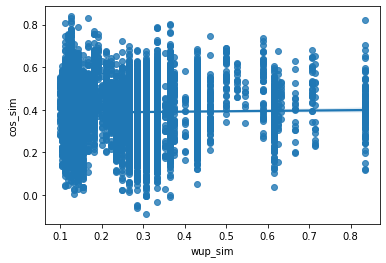

In [48]:
#dfSample = df.sample(1000, weights='wup_sim') # This is the importante line
#xdataSample, ydataSample = dfSample["cos_sim"], dfSample["wup_sim"]

lineminus1 = line[line['wup_sim'] != 1]

xdataSample, ydataSample = lineminus1["cos_sim"], lineminus1["wup_sim"]

sns.regplot(x=ydataSample, y=xdataSample) 
plt.show()

In [50]:
foursenses = df[df['n_senses'] == 4]['lemma'].unique()
foursenses

array(['structure', 'need', 'washington', 'idea', 'growth', 'amount',
       'earth', 'pain', 'box', 'hour', 'range', 'motif', 'game',
       'material', 'water', 'example', 'rank', 'second', 'product',
       'share', 'fork', 'film', 'start', 'officer', 'distribution',
       'mess', 'help', 'provision', 'administration', 'bloom', 'fly',
       'replacement', 'spread', 'conversion', 'hearing', 'trouble',
       'contribution', 'bill', 'affair', 'question', 'match',
       'production', 'function', 'community', 'literature', 'hope',
       'bolt', 'boy', 'living', 'target', 'eye', 'circumstance', 'brain',
       'nerve', 'office', 'lesson', 'church', 'gain', 'sphere', 'roll',
       'capital', 'room', 'trace', 'post', 'program', 'reception',
       'memory', 'wire', 'report', 'watch', 'nature', 'balance', 'item',
       'truth', 'interference', 'floor', 'leadership', 'prayer', 'faith',
       'act', 'energy', 'quality', 'card', 'limit', 'exercise', 'fact',
       'politics', 'distance'

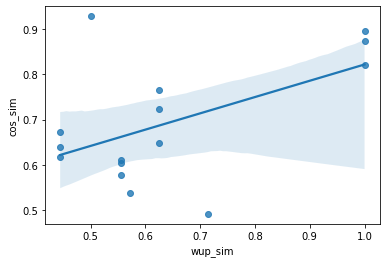

In [54]:
discip = df[df['lemma'] == 'crash']


xdataSample, ydataSample = discip["cos_sim"], discip["wup_sim"]

sns.regplot(x=ydataSample, y=xdataSample) 
plt.show()

In [53]:
df.head(5)

Unnamed: 0          lemma                     token_sense_1  \
0           0  communication  communication.n.01.communication   
1           1  communication  communication.n.01.communication   
2           2  communication  communication.n.01.communication   
3           3  communication  communication.n.01.communication   
4           4  communication  communication.n.01.communication   

                      token_sense_2 sense1_pos sense2_pos   cos_sim  wup_sim  \
0  communication.n.01.communication          n          n  0.828119      1.0   
1  communication.n.01.communication          n          n  0.708595      1.0   
2  communication.n.01.communication          n          n  0.798475      1.0   
3  communication.n.01.communication          n          n  0.726443      1.0   
4  communication.n.01.communication          n          n  0.862673      1.0   

   n_senses  n_word_forms  concreteness  wn_bin  conc_bin  
0         3             2           2.9       2       2.0  
1         3             2           2.9       2       2.0  
2         3             2           2.9       2       2.0  
3         3             2           2.9       2       2.0  
4         3             2           2.9       2       2.0